In [1]:
import numpy as np
import pandas as pd
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
diffusion="5.0percent"
# file_id = "1"
file_id = "2954"


# hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_5.0percent_smear_{file_id}.h5", "MC/hits")


display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,event_id,x,y,z,energy
0,20985000,524.575012,28.776987,124.380753,0.000074
1,20985000,524.548035,31.485611,124.528938,0.004687
2,20985000,529.095703,30.907675,128.522736,0.000074
3,20985000,523.641113,28.530880,128.811050,0.023610
4,20985000,523.204407,31.749161,129.115723,0.462297
...,...,...,...,...,...
10873,20985059,-138.245743,-659.412109,1717.046265,0.001910
10874,20985059,-138.098022,-665.070007,1717.059204,0.006870
10875,20985059,-138.725021,-672.616821,1717.734131,0.000273
10876,20985059,-144.862320,-672.259094,1718.242310,0.000074


[20985000 20985001 20985002 20985003 20985004 20985005 20985006 20985007
 20985008 20985009 20985010 20985011 20985012 20985013 20985014 20985015
 20985016 20985017 20985018 20985019 20985020 20985021 20985022 20985023
 20985024 20985025 20985026 20985027 20985028 20985029 20985030 20985031
 20985032 20985033 20985034 20985035 20985036 20985037 20985038 20985039
 20985040 20985041 20985042 20985043 20985044 20985045 20985046 20985047
 20985048 20985049 20985050 20985051 20985052 20985053 20985054 20985055
 20985056 20985057 20985058 20985059]


In [2]:
eid=320000
eid=event_list[7]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
362,20985007,225.799393,385.219879,666.507141,0.029884
363,20985007,240.951874,387.927063,668.148193,0.205939
364,20985007,240.472519,383.897797,669.921753,0.275156
365,20985007,253.942261,392.128296,671.137695,0.060785
366,20985007,244.650955,377.150787,671.203308,0.051510
367,20985007,248.699615,377.473450,671.365845,0.146419
368,20985007,242.221939,375.929749,671.608398,0.036183
369,20985007,249.427719,392.349274,671.915710,0.043896
370,20985007,260.955139,384.481598,672.047302,0.032066
371,20985007,250.063904,375.405243,672.224731,0.124124


In [3]:

Diff_smear = 0.0
energy_threshold=0
diff_scale_factor=7 # this scales the radius size

# The percentage 0 is actually a small amount
if (diffusion == "0.05percent"):
    Diff_smear = 0.05 # mm / sqrt(cm)
elif (diffusion == "0.1percent"):
    Diff_smear = 0.95 # mm / sqrt(cm)
elif (diffusion == "0.25percent"):
    Diff_smear = 0.703 # mm / sqrt(cm)
elif (diffusion == "0.5percent"):
    Diff_smear = 0.507 # mm / sqrt(cm)
elif (diffusion == "5.0percent"):

    if (pressure == 1):
        Diff_smear = 0.290 # mm / sqrt(cm)
        diff_scale_factor=7
    elif (pressure == 5):
        Diff_smear = 0.270
        diff_scale_factor=5
        energy_threshold=0.001
    elif (pressure == 10):
        Diff_smear = 0.251
        diff_scale_factor=5
        energy_threshold=0.001
    elif (pressure == 15):
        Diff_smear = 0.258
        diff_scale_factor=5
        energy_threshold=0.001
    else:
        print("Error pressure not found")
else:
    print("Error CO2 percentage not defined at 75 V/cm field")

if (Diff_smear == 0.0):
    print("Error diffusion value not configured properly")


mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw=mean_sigma
xmin=-det_size - mean_sigma/2 
xmax=det_size + mean_sigma/2

ybw=mean_sigma
ymin=-det_size - mean_sigma/2 
ymax=det_size + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

xbw=mean_sigma
xmin=-det_size - mean_sigma/2 
xmax=det_size + mean_sigma/2

ybw=mean_sigma
ymin=-det_size - mean_sigma/2 
ymax=det_size + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

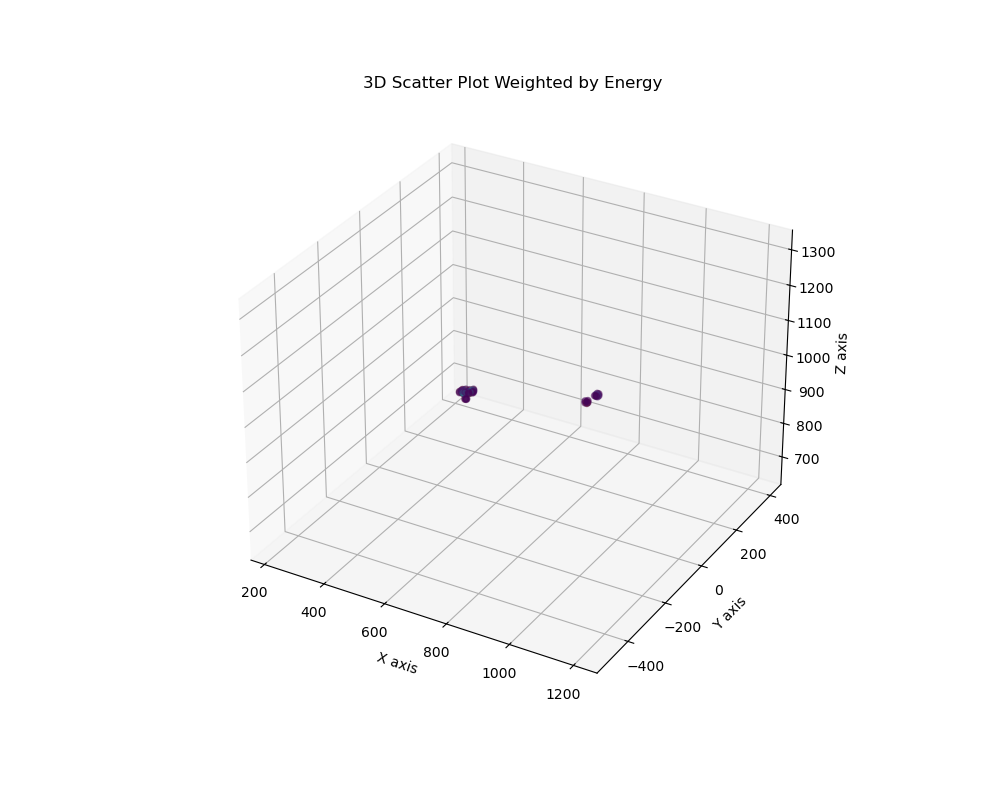

In [4]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


data = CutandRedistibuteEnergy(data, energy_threshold)

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [5]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

display(data)
print(len(dist_matrix))

,event_id,x,y,z,energy
0,20985007,225.453690,385.108582,663.831116,0.006621
1,20985007,225.582138,385.046600,667.397888,0.020436
2,20985007,236.962341,385.881714,664.025818,0.003311
3,20985007,237.566696,376.663269,677.376892,0.013516
4,20985007,237.652466,382.599030,677.552490,0.020560
5,20985007,237.679962,384.744324,669.768005,0.095830
6,20985007,237.696732,376.159760,672.410645,0.016528
7,20985007,237.867249,390.265747,668.899719,0.011973
8,20985007,241.585892,386.184021,664.090210,0.011923
9,20985007,241.718811,383.754028,677.116211,0.053740


54


Mean z: 860.7273  diffusion =  12
Mean Sigma:  12
11 2.313269615639001


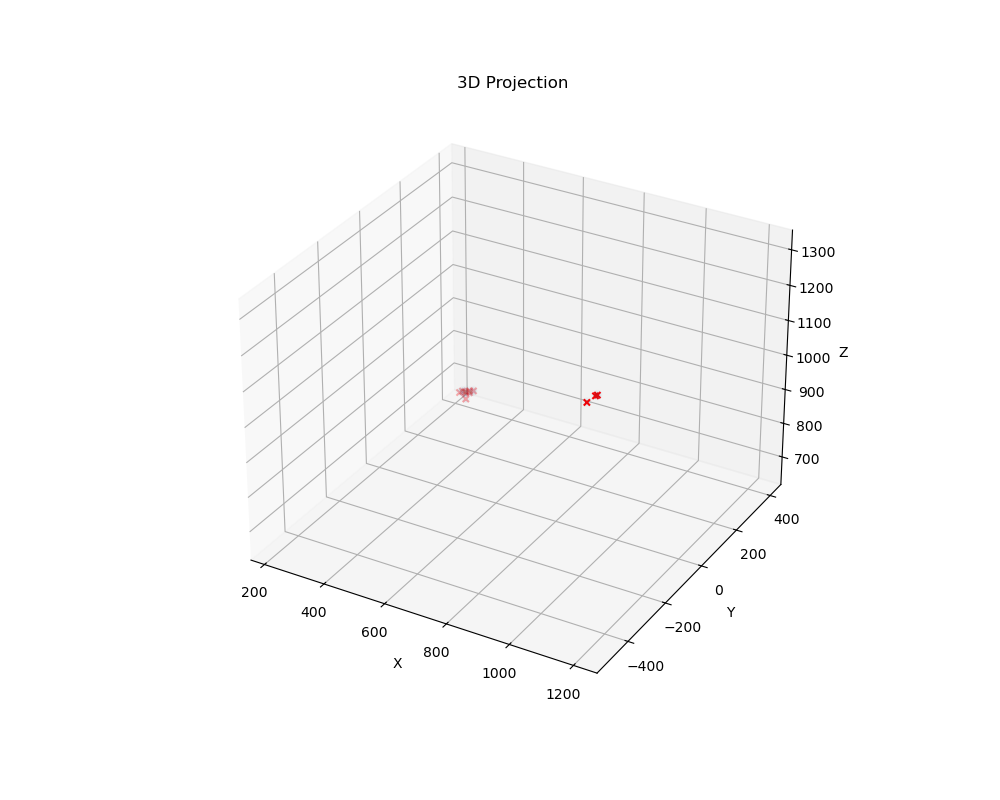

In [6]:

def GetMinima(index, all_visited_, input_data, temp_dist_matrix, R):


    distances_from_index = temp_dist_matrix[index] # distances for node to others
    sorted_indices = np.argsort(distances_from_index) # indexes sorted by smallest distance

    closest_nodes = sorted_indices[distances_from_index[sorted_indices] < R]
    
    closest_nodes = list(set(closest_nodes) - set(all_visited_))

    selected_rows = input_data.iloc[closest_nodes] # Df containing the nodes within distance

    # Compute the mean of x, y, and z columns
    mean_x = selected_rows['x'].median()
    mean_y = selected_rows['y'].median()
    mean_z = selected_rows['z'].median()
    energy_sum = selected_rows['energy'].sum()
    mean_point = np.array([mean_x, mean_y, mean_z, energy_sum])

    all_visited = all_visited_ + list(closest_nodes)

    return mean_point, all_visited


def Cluster(input_data, R):

    node_centers = []
    all_visited = []
    indexes = input_data.index.values
    indexes_set = set(indexes)

    temp_dist_matrix = distance_matrix(input_data[['x', 'y', 'z']], input_data[['x', 'y', 'z']])

    for i in range(len(input_data)):

        all_visited_set = set(all_visited)

        # Convert arrays to sets and perform the difference
        filtered_indexes = list(indexes_set - all_visited_set)

        if not filtered_indexes:
            break

        # random_index = np.random.choice(filtered_indexes)
        random_index = filtered_indexes[0]
        median, all_visited = GetMinima(random_index, all_visited, input_data, temp_dist_matrix, R)

        node_centers.append(median)

    return pd.DataFrame(node_centers, columns=['x', 'y', 'z', 'energy'])


print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)

# mean_sigma = round(6*0.29*np.sqrt(0.1*data.z.mean()))
# mean_sigma = round(6*0.9*np.sqrt(0.1*data.z.mean()))
print("Mean Sigma: ", mean_sigma)

node_centers_df = Cluster(data, mean_sigma)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 30)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 75)

# display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')

ax.scatter(node_centers_df['x'], node_centers_df['y'], node_centers_df['z'], marker='x',c="r")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



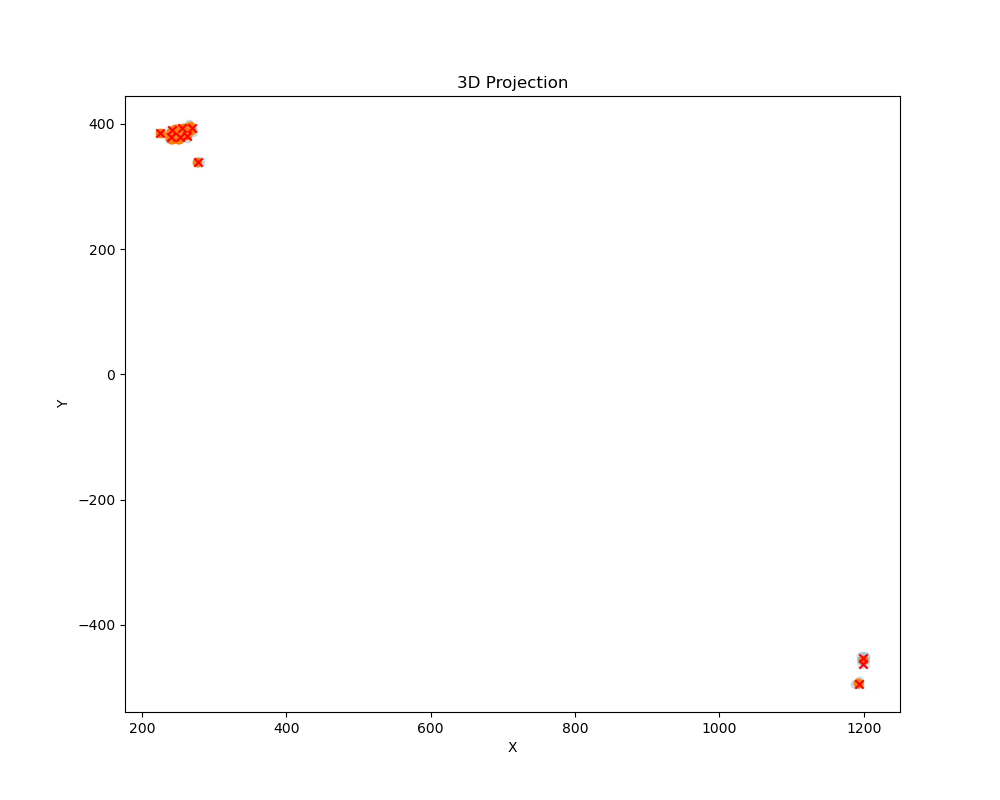

In [7]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
plt.scatter(data_true['x'], data_true['y'], marker='o')
plt.scatter(node_centers_df['x'], node_centers_df['y'], marker='x',c="r")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()


In [8]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum']            # Sum energy
    })

# Create final DataFrame
databin = pd.DataFrame(result)
display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy
0,20985007.0,224.0,380.0,660.0,225.582138,385.108582,664.025818,0.030367
1,20985007.0,236.0,380.0,672.0,239.707764,379.631165,674.602966,0.820980
2,20985007.0,236.0,392.0,672.0,241.790237,390.265747,668.899719,0.159302
3,20985007.0,248.0,380.0,672.0,252.756363,379.278198,673.963379,0.218319
4,20985007.0,260.0,392.0,672.0,256.050201,393.020660,673.166138,0.224567
5,20985007.0,260.0,380.0,672.0,262.848816,380.995636,674.753479,0.431212
6,20985007.0,272.0,392.0,672.0,269.991089,392.832214,676.693115,0.204654
7,20985007.0,272.0,344.0,684.0,277.875549,339.113647,679.490601,0.035271
8,20985007.0,1196.0,-496.0,1308.0,1192.867432,-494.345947,1304.508057,0.031860
9,20985007.0,1196.0,-448.0,1308.0,1198.966309,-452.739136,1305.405640,0.153553


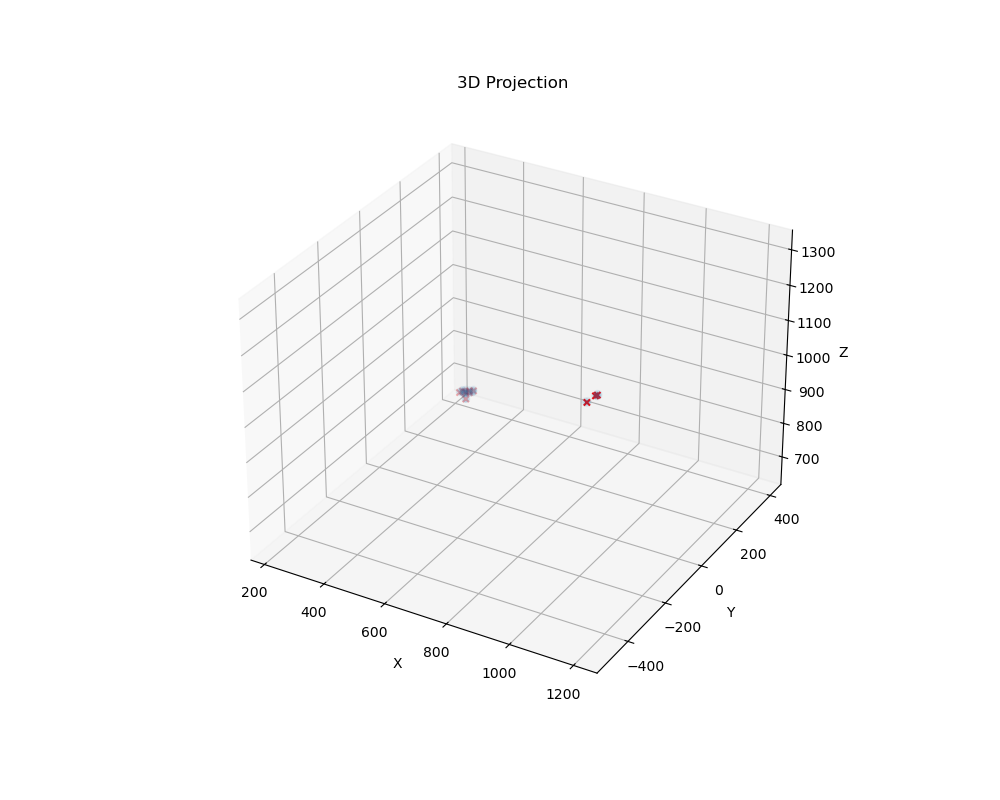

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")

ax.scatter(databin['x'], databin['y'], databin['z'], marker='x',c="r")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

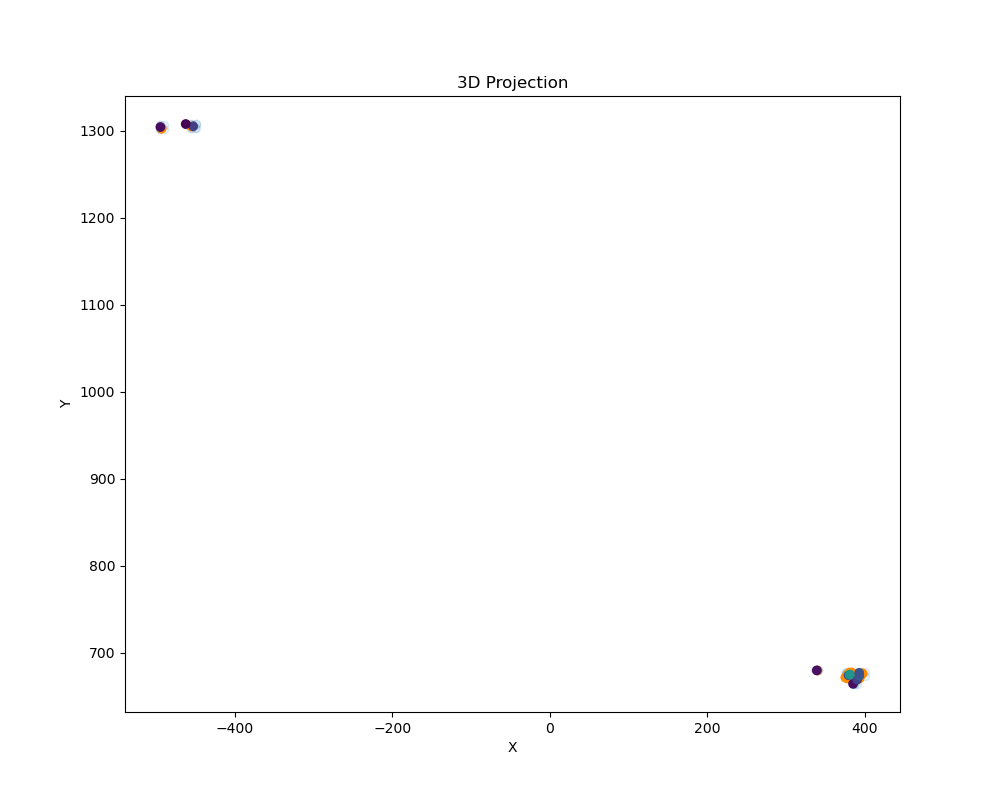

In [10]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['y'], data['z'], marker='o',alpha=0.1)
plt.scatter(data_true['y'], data_true['z'], marker='o',color="DarkOrange")
# plt.scatter(data_true['y'], data_true['z'], marker='o',c=data_true["energy"])
plt.scatter(databin['y'], databin['z'], marker='o',c=databin['energy'])

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()

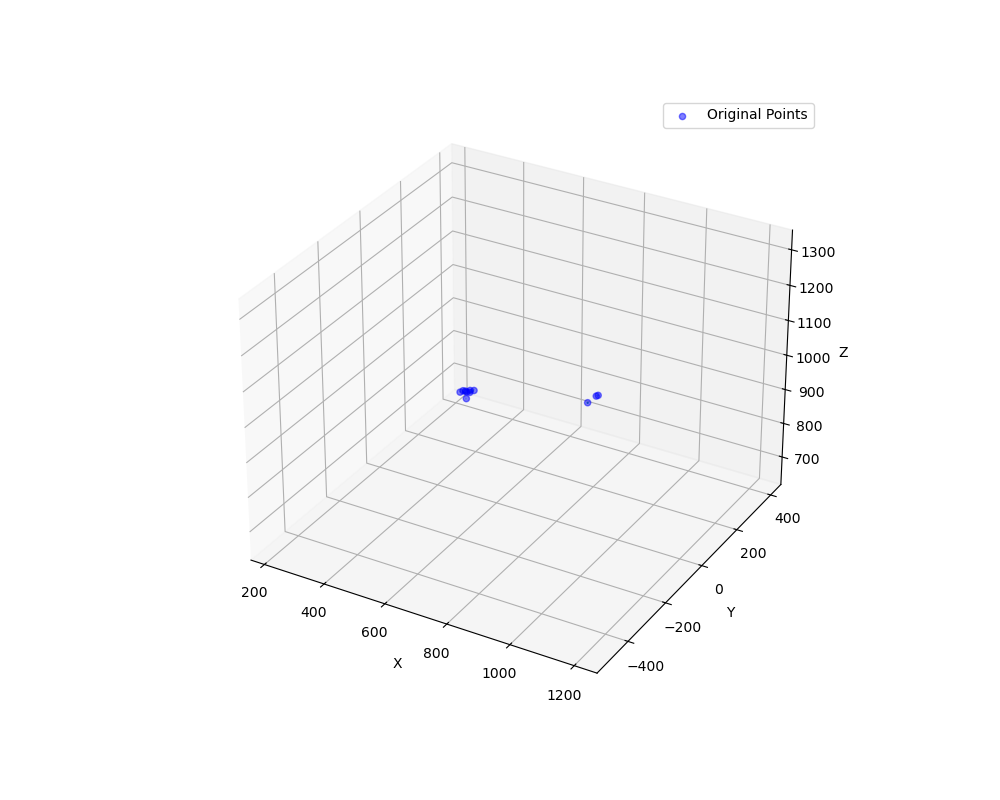

In [11]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

,event_id,x_smear,y_smear,z_smear,x,y,z,energy
0,20985007.0,224.0,380.0,660.0,225.582138,385.108582,664.025818,0.030367
1,20985007.0,236.0,380.0,672.0,239.707764,379.631165,674.602966,0.820980
2,20985007.0,236.0,392.0,672.0,241.790237,390.265747,668.899719,0.159302
3,20985007.0,248.0,380.0,672.0,252.756363,379.278198,673.963379,0.218319
4,20985007.0,260.0,392.0,672.0,256.050201,393.020660,673.166138,0.224567
5,20985007.0,260.0,380.0,672.0,262.848816,380.995636,674.753479,0.431212
6,20985007.0,272.0,392.0,672.0,269.991089,392.832214,676.693115,0.204654
7,20985007.0,272.0,344.0,684.0,277.875549,339.113647,679.490601,0.035271
8,20985007.0,1196.0,-496.0,1308.0,1192.867432,-494.345947,1304.508057,0.031860
9,20985007.0,1196.0,-448.0,1308.0,1198.966309,-452.739136,1305.405640,0.153553


Median distance to the closest row: 12.245736786715753
Distances to iterate over [ 1  2  4  6  7  9 11 12 14 16 17 19 21 22 24]
Dist Thresh 52.276
Pass Flag: True
The primary track is:  0
      event_id            x           y            z    energy  id  primary  \
0   20985007.0   277.875549  339.113647   679.490601  0.035271   7        1   
1   20985007.0   262.848816  380.995636   674.753479  0.431212   5        1   
2   20985007.0   252.756363  379.278198   673.963379  0.218319   3        1   
3   20985007.0   239.707764  379.631165   674.602966  0.820980   1        1   
4   20985007.0   241.790237  390.265747   668.899719  0.159302   2        1   
5   20985007.0   225.582138  385.108582   664.025818  0.030367   0        1   
6   20985007.0   256.050201  393.020660   673.166138  0.224567   4        0   
7   20985007.0   269.991089  392.832214   676.693115  0.204654   6        0   
8   20985007.0  1192.867432 -494.345947  1304.508057  0.031860   8        0   
9   20985007.0  1198.8

,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,
7,20985007.0,277.875549,339.113647,679.490601,0.035271,7,1,0,0.000000,0.000000,1.374048,0.643916
5,20985007.0,262.848816,380.995636,674.753479,0.431212,5,1,0,44.747559,150.756749,1.374048,0.643916
3,20985007.0,252.756363,379.278198,673.963379,0.218319,3,1,0,55.015541,79.533168,1.374048,0.643916
1,20985007.0,239.707764,379.631165,674.602966,0.820980,1,1,0,68.084573,13.323278,1.374048,0.643916
2,20985007.0,241.790237,390.265747,668.899719,0.159302,2,1,0,80.330310,99.737199,1.374048,0.643916
0,20985007.0,225.582138,385.108582,664.025818,0.030367,0,1,0,98.023635,106.296898,1.374048,0.643916
4,20985007.0,256.050201,393.020660,673.166138,0.224567,4,0,1,13.904748,117.856380,1.000000,0.000000
6,20985007.0,269.991089,392.832214,676.693115,0.204654,6,0,1,28.286105,120.883606,1.000000,0.000000
8,20985007.0,1192.867432,-494.345947,1304.508057,0.031860,8,0,2,0.000000,0.000000,1.014903,0.087383


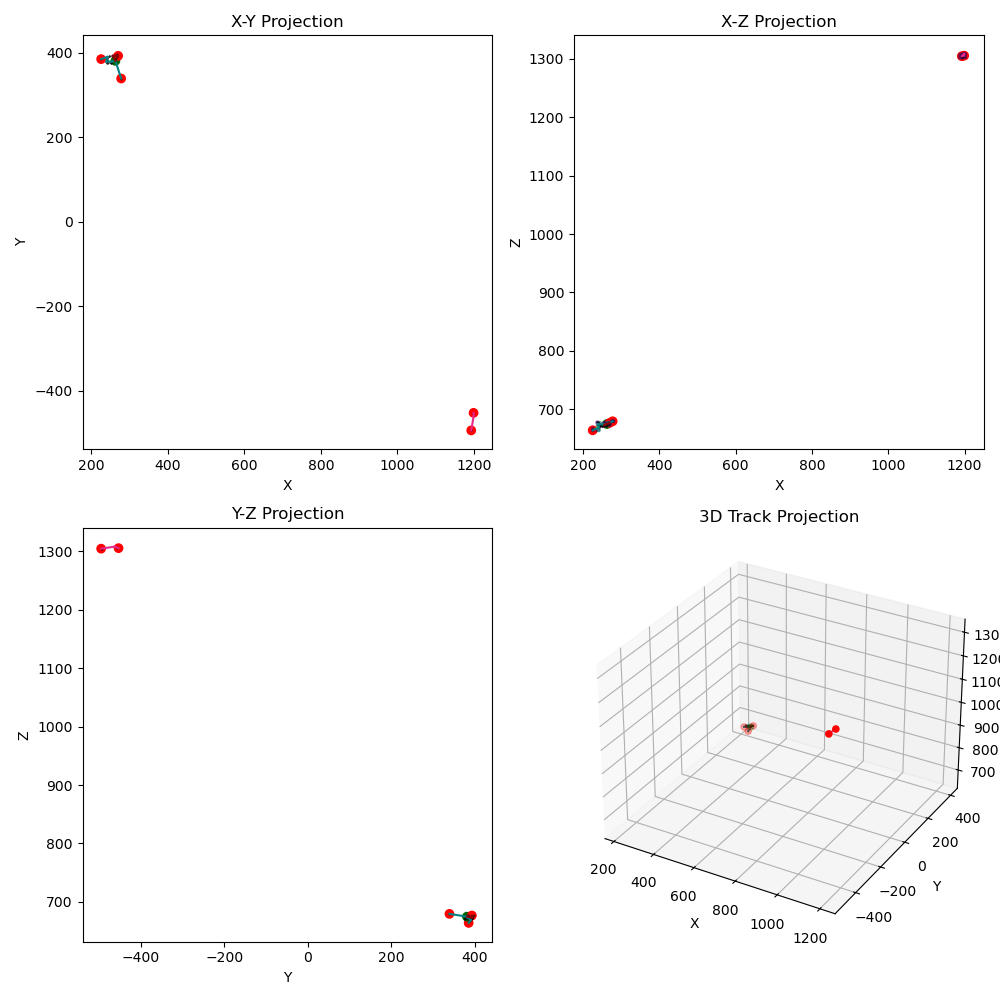

In [12]:
# Apply the tracking reconstruction

display(databin)


df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)

plt.tight_layout()
plt.show()

In [13]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

distance_threshold, radius_threshold, T_threshold, pressure:  33.333333333333336 12.0 13.333333333333334 15
end_tresh: 84.6903014928833 98.02363482621662 13.333333333333334 15 2
      event_id           x           y           z    energy  id  primary  \
id                                                                          
2   20985007.0  241.790237  390.265747  668.899719  0.159302   2        1   
0   20985007.0  225.582138  385.108582  664.025818  0.030367   0        1   

    trkID  cumulative_distance       angle  Tortuosity  Squiglicity  
id                                                                   
2       0            80.330310   99.737199    1.374048     0.643916  
0       0            98.023635  106.296898    1.374048     0.643916  
end_tresh: 84.6903014928833 98.02363482621662 13.333333333333334 15 2
      event_id           x           y           z    energy  id  primary  \
id                                                                          
2   20985

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,20985007.0,0,1,0,7,42.688,1.695450,1.010649,0.035271,0.030367,0.035271,1.374048,1.374048,364.672267,922.279644,0.643916,0.643916,170.895183,432.204921,Primary
0,20985007.0,1,0,5,6,28.286,0.429220,0.429220,0.429220,0.000000,0.204654,1.000000,1.000000,215.720353,215.720353,1.000000,1.000000,1.000000,1.000000,Delta0
0,20985007.0,2,0,8,10,42.688,0.188599,0.035047,0.156739,0.031860,0.156739,1.014903,1.014903,500.830704,149.029782,0.087383,0.087383,43.121548,12.831472,Brem


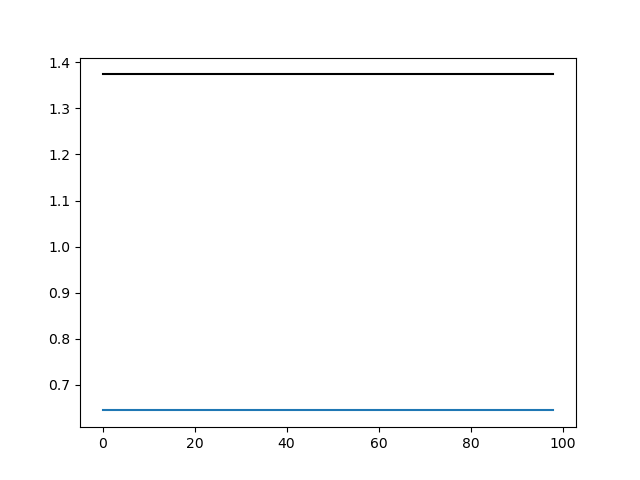

In [14]:
plt.figure()

plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Tortuosity, color="k");
plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Squiglicity);